# Econometrics III - Problem set 2
### Javier Viviens Martín 

PhD in Economics - European University Institute. \
Course 2022-2023

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import statsmodels.api as sm
import pandas as pd

### Exercise 1

In [2]:
datuak = pd.read_excel("UNRATE.xls") #Upload the data
datuak = datuak.to_numpy() #convert to numpy

##### a. Using conditional maximum likelihood, estimate the models that you thought (from the previous problem set) could match the data relatively well. Report standard errors of the estimated coefficients using the Fisher information matrix.

In the previous problem set I argued that an AR(1) process is the model that would match the data process:

$$ y_{t} = c + \phi y_{t-1} + \varepsilon_{t}$$

with an AR(2) as a second candidate:

$$ y_{t} = c + \phi_{1} y_{t-1} +\phi_{2} y_{t-2}+ \varepsilon_{t}$$

From the slides, we know that the conditional MLE coincides with the $\hat \phi$ that we obtain using OLS. So I will take profit of this fact to estimate my parameters of interest.

In [3]:
T = len(datuak) #Save number of periods in the sample.
berri_datuak = np.zeros(T) 
for i in range(0,T): #Get observations in an array (before it was T arrays of 1 element each).
    berri_datuak[i] = datuak[i][0]

AR(1)

In [4]:
y = berri_datuak[1:] #define endogenous variable.
x = np.array([ np.ones(T-1), berri_datuak[:-1]]) #define regressors.
x = np.transpose(x)
AR1 = sm.OLS(endog=y, exog=x) #Run OLS.
phi_bat = AR1.fit().params #Get coefficients.
phi_bat

array([0.18436172, 0.96861345])

AR(2)

In [5]:
#Exactly the same as before, but changing number of lags and therefore regressors and endogenous var.
y = berri_datuak[2:]
x = np.array([ np.ones(T-2), berri_datuak[1:-1] , berri_datuak[:-2]])
x = np.transpose(x)
AR2 = sm.OLS(endog=y, exog=x)
phi_bi = AR2.fit().params
phi_bi

array([ 0.19300545,  1.02197973, -0.0549226 ])

For some reason I don't understand, the command $\texttt{sm.OLS(endog, exog).information(params)}$, that would give me the Fisher information matrix, is giving me an error. Luckily for me, the standard errors of the OLS regression are computed with the Information matrix, so I can access directly to the desired results:

In [6]:
#Get the standard errors
se_AR1 = AR1.fit().bse 
se_AR2 = AR2.fit().bse

In [7]:
#Put everything together.
AR1_results = pd.DataFrame([phi_bat , se_AR1])
AR1_results.set_axis(['c', '$\phi$'], axis='columns', inplace=True)
AR1_results.set_axis(['coef', 'se'], axis='rows', inplace=True)
AR2_results = pd.DataFrame([phi_bi , se_AR2])
AR2_results.set_axis(['c', '$\phi_{1}$','$\phi_{2}$'], axis='columns', inplace=True)
AR2_results.set_axis(['coef', 'se'], axis='rows', inplace=True)

In [8]:
AR1_results

,c,$\phi$
coef,0.184362,0.968613
se,0.050141,0.008336


In [9]:
AR2_results

,c,$\phi_{1}$,$\phi_{2}$
coef,0.193005,1.02198,-0.054923
se,0.050509,0.03385,0.033830


##### b. Compute the Bayesian Information criteria and the Akaike Information criteria for selecting one of these models. Do they agree?

$$ AIC = 2 * k - 2 * L$$ 

$$ BIC = log(T )*k − 2 * L$$

where L is the log-likelihood

In [10]:
AIC_1 = 2*2 - 2*AR1.loglike(phi_bat)
AIC_2 = 2*3 - 2*AR2.loglike(phi_bi)
BIC_1 = np.log(T-1)*2 -2*AR1.loglike(phi_bat)
BIC_2 = np.log(T-1)*3 - 2*AR2.loglike(phi_bi)

In [11]:
if AIC_1 < AIC_2:
    print("AR(1) is preferred to AR(2) according to AIC.")
elif AIC_1 > AIC_2:
    print("AR(2) is preferred to AR(1) according to AIC.")
else:
    print("both models yields the same AIC.")

AR(2) is preferred to AR(1) according to AIC.


In [12]:
if BIC_1 < BIC_2:
    print("AR(1) is preferred to AR(2) according to BIC.")
elif BIC_1 > BIC_2:
    print("AR(2) is preferred to AR(1) according to BIC.")
else:
    print("both models yields the same BIC.")

AR(1) is preferred to AR(2) according to BIC.


The criteria do not coincide. For the next exercises I will proceed with the AR(1) as preferred model since I know from the previous problem set that HQIC also yields AR(1) as preferred over AR(2).

##### c. For the model that best fits the data, fix all the model’s parameter to their conditional MLE. Create a narrow grid around the conditional MLE for the variance of the error term and plot how the likelihood function decreases as you move away from its MLE (create a narrow grid close the the MLE and evaluate the likelihood for 100 neighboring points).

The log likelihood of an AR(1) process with a constant is given by:

$$
\begin{gathered}
\mathcal{L}(\boldsymbol{\theta})=-\frac{1}{2} \log (2 \pi)-\frac{1}{2} \log \left[\sigma^2 /\left(1-\phi^2\right)\right]-\frac{\left\{y_1-[c /(1-\phi)]\right\}^2}{2 \sigma^2 /\left(1-\phi^2\right)} 
-[(T-1) / 2] \log (2 \pi)-[(T-1) / 2] \log \left(\sigma^2\right)-\sum_{t=2}^T\left[\frac{\left(y_t-c-\phi y_{t-1}\right)^2}{2 \sigma^2}\right]
\end{gathered}
$$

In [13]:
y = berri_datuak[1:]  #define again y for the AR(1) process.
T = len(y) #Define number of obs.

In [14]:
sig2 = np.cov(AR1.fit().resid,AR1.fit().resid)[0,0] #MLE of sigma^{2}.
sig = np.sqrt(sig2)
phi = phi_bat[1] #MLE of phi.
c = phi_bat[0] #MLE of c.

In [15]:
loglike = lambda sigma: -np.log(2*np.pi)/2 - (np.log((sigma**2)/(1-phi**2)))/2 - (y[0] - (c/(1-phi)))**2/((2*sigma**2)/(1-phi**2)) - ((T-1)/2)*np.log(2*np.pi) - ((T-1)/2)*np.log(sigma**2) -sum(AR1.fit().resid[1:]**2)/(2*sigma**2) 

In [16]:
#I don't know exactly what a narrow grid means, so I will take a grid of the forn: [0.8*Sigma_{MLE},1.2*Sigma_{MLE}]
grid = np.linspace(0.8*sig, 1.2*sig,101) #I will take 101 so that grid[50] = MLE and I have 100 neighbouring points.
L = np.zeros(len(grid))
for i in range(0,len(L)):
    L[i] = loglike(grid[i])
np.max(L), L[50] #Check that actually the MLE gives tha maximum value of the log likelihood.

(-482.9652470910823, -482.9652470910823)

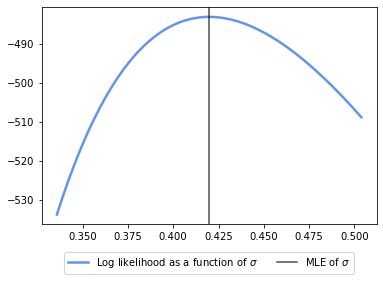

In [17]:
plt.plot(grid, L, color='cornflowerblue',linewidth = 2.5, label = 'Log likelihood as a function of $\sigma$')
plt.axvline(x = grid[50], color = 'black', label = 'MLE of $\sigma$',alpha=0.7)
plt.legend(loc = 'lower center',ncol=3, bbox_to_anchor=(0.5, -0.25))
plt.show()

##### d. Generate the impulse response function for the model that fits the data the better.

Since it's an AR(1) process, it's enough with the parameter $\hat \phi$ to get the IRF:

In [18]:
h = 30
IRF = np.zeros(h)
for i in range(0,h):
    IRF[i] = phi_bat[1]**i

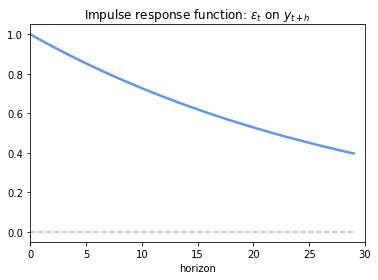

In [19]:
plt.plot(range(0,h),IRF, color = 'cornflowerblue',linewidth = 2.5 )
plt.plot(range(0,h),np.zeros(h), '--', color = 'silver')
plt.title("Impulse response function: $ \epsilon_{t}$ on $y_{t+h}$")
plt.xlabel("horizon")
plt.xlim(0, h)
plt.show()

You can observe that the shock is quite persistent.

### Exercise 2

Consider:

$$ \begin{bmatrix} x_{t}  \\ y_{t} \end{bmatrix} =  \begin{bmatrix} 0.5 & 0.3  \\ 0.1  & 0.8 \end{bmatrix}\begin{bmatrix} x_{t}  \\ y_{t} \end{bmatrix} + \epsilon_{t}$$

with

$$ \epsilon_{t} \sim N(0,\Omega) , \Omega = \begin{bmatrix} 1 & 0.3 \\ 0.3 & 1 \end{bmatrix} $$

##### a.  Is the process covariance-stationary?

In [20]:
F = np.matrix('0.5 0.3 ;0.1 0.8') #Companion Matrix
np.linalg.eig(F) # Eigen values of F. 

(array([0.42087122, 0.87912878]),
 matrix([[-0.96693047, -0.62052031],
         [ 0.25504011, -0.78419037]]))

The eigenvalues of the matrix are lower than one in modulus, therefore I can conclude that the process is stationary.

##### b. Plot the impulse response function of a one-standard deviation shock.

In [21]:
h = 30 #Number of horizons we want to plot the IRF.
IRF = np.zeros((h,2,2)) #Here I will save the IRFS.
for i in range(0,h):
    A = F**i
    IRF[i,0,0] = A[0,0] #Effect of shock of x on x.
    IRF[i,0,1] = A[0,1] #Effect of shock of y on x.
    IRF[i,1,0] = A[1,0] #Effect of shock of x on y.
    IRF[i,1,1] = A[1,1] #Effect of shock of y on y.

Text(0.5, 1.0, '$y_{t}$ on $y_{t+h}$')

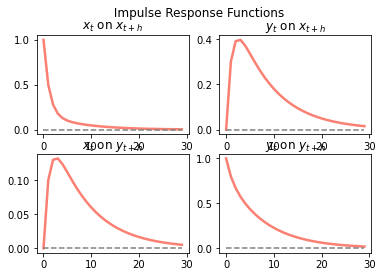

In [22]:
fig, axs = plt.subplots(2, 2)
fig.suptitle(' Impulse Response Functions ')
axs[0, 0].plot(range(0,h),IRF[:,0,0], linewidth = 2.5, color = 'salmon',alpha = 2)
axs[0, 0].plot(range(0,h),np.zeros(h), '--', color = 'grey')
axs[0, 0].set_title('$x_{t}$ on $x_{t+h}$')
axs[0, 1].plot(range(0,h),IRF[:,0,1], linewidth = 2.5, color = 'salmon',alpha = 2)
axs[0, 1].plot(range(0,h),np.zeros(h), '--', color = 'grey')
axs[0, 1].set_title('$y_{t}$ on $x_{t+h}$')
axs[1, 0].plot(range(0,h),IRF[:,1,0], linewidth = 2.5, color = 'salmon',alpha = 2)
axs[1, 0].plot(range(0,h),np.zeros(h), '--', color = 'grey')
axs[1, 0].set_title('$x_{t}$ on $y_{t+h}$')
axs[1, 1].plot(range(0,h),IRF[:,1,1], linewidth = 2.5, color = 'salmon',alpha = 2)
axs[1, 1].plot(range(0,h),np.zeros(h), '--', color = 'grey')
axs[1, 1].set_title('$y_{t}$ on $y_{t+h}$')

##### c. Simulate one sample of size $T = 500$ by taking random draws from $\epsilon$ and setting $x_{1} = y_{1} = 0$.

In [23]:
mean = [0, 0] #Mean of \epsilon.
cov = [[1, 0.3], [0.3, 1]] #Variance covariance matrix of \epsilon.
T = 500 #Number of periods simulated.
shocks = np.random.multivariate_normal(mean, cov, size = T)[:] #Simulate shocks.
ex = shocks[:,0] #Shocks to x.
ey = shocks[:,1] #Shocks to y.
x = np.zeros(T)
y = np.zeros(T)
x[0] = ex[0] #Initial values normalized to zero.
y[0] = ey[0]
for i in range(1,T):
    x[i] = F[0,0]*x[i-1] +F[0,1]*y[i-1] + ex[i]
    y[i] = F[1,0]*x[i-1] +F[1,1]*y[i-1] + ey[i]

Text(0.5, 1.0, '$y_{t}$')

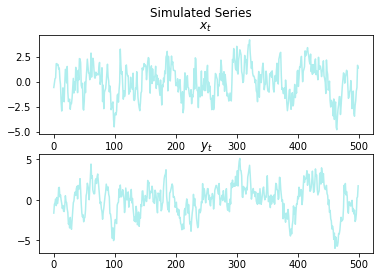

In [24]:
fig, axs = plt.subplots(2)
fig.suptitle('Simulated Series')
axs[0].plot(range(0,T), x, color = 'paleturquoise')
axs[0].set_title('$x_{t}$')
axs[1].plot(range(0,T), y,color = 'paleturquoise')
axs[1].set_title('$y_{t}$')

##### d. From your simulated sample, estimate the coefficients of a VAR(1).

In [25]:
#The MLE estimator is just (X'X)^-1X'Y. So I define these matrices:
Y = np.zeros((T-1,2))
X = np.zeros((T-1,2))
for i in range(0,T-1):
    Y[i,0] = x[i+1]
    Y[i,1] = y[i+1]
    X[i,0] = x[i]
    X[i,1] = y[i]
Y = np.matrix(Y)
X = np.matrix(X)

In [26]:
phit = (np.transpose(X)*X)**(-1)*np.transpose(X)*Y #And get $\hat Phi transposed

In [27]:
Phi = np.transpose(phit)

$\hat \Phi$ is equal to:

In [28]:
Phi

matrix([[0.48929362, 0.29317635],
        [0.09250908, 0.80580239]])

In [29]:
#To compute the estimation of \Omega, I will use the fact that the MLE of \Omega coincides with sample 
#variance-covariance matrix of the n OLS residuals:
#First, I define the regressors:
X = np.array([x[:-1],y[:-1]])
X = np.transpose(X)
#Regress OLS for x:
results_x = sm.OLS(endog=x[1:],exog=X).fit()
#Regress OLS for y:
results_y = sm.OLS(endog=y[1:],exog=X).fit()
#Get Sample variance-covariance:
Omega = np.cov(results_x.resid,results_y.resid)

$\hat \Omega$ is equal to:

In [30]:
Omega

array([[0.9824324 , 0.32942252],
       [0.32942252, 0.95427161]])

In [31]:
[Phi[0,:], results_x.params] , [Phi[1,:], results_y.params] #Check that what I did to compute Phi and OLS results coincide.

([matrix([[0.48929362, 0.29317635]]), array([0.48929362, 0.29317635])],
 [matrix([[0.09250908, 0.80580239]]), array([0.09250908, 0.80580239])])

##### e. Using you sample, does variable y granger cause x? Does variable x granger cause y?

In this particular case, where there is only 1 lag, I only need to test is one parameter of interest is different from zero. Hence, there's no need to run any F-test, it's enough to run a simple t-test for a single hypothesis. Since I have already run the respective OLS regressions, it's enough to check the p-values of those regressions. I will state that y Granger causes x if I can reject the null that $\phi_{1,2} = 0$ at the 1% confidence level. Similarly, I will state that x Granger causes y if I can reject the null $H_{0}: \phi_{2,1} = 0$ at the 1% confidence level.

In [32]:
if results_x.pvalues[1]<0.01:
    print("y Granger causes x.")
else:
    print("y Granger does not cause x.")

y Granger causes x.


In [33]:
if results_y.pvalues[0]<0.01:
    print("x Granger causes y.")
else:
    print("x Granger does not cause y.")

x Granger does not cause y.


##### f. Compute and plot the IRFs from your estimated VAR with 95% confidence bands. How does it compare with your answer in b?

In [34]:
#I will compute the estimated IRF in the same way as in b, but using Phi hat instead of the real F:
IRF_est = np.zeros((h,2,2)) #Here I will save the IRFS.
for i in range(0,h):
    A = Phi**i
    IRF_est[i,0,0] = A[0,0] #Effect of shock of x on x.
    IRF_est[i,0,1] = A[0,1] #Effect of shock of y on x.
    IRF_est[i,1,0] = A[1,0] #Effect of shock of x on y.
    IRF_est[i,1,1] = A[1,1] #Effect of shock of y on y.

In [35]:
#I will compute the confidence interval of the IRF using directly the CI provided by the OLS regression.
PEL = np.zeros((2,2))
PEL[0,0] = results_x.conf_int(alpha=0.05)[0][0]
PEL[0,1] = results_x.conf_int(alpha=0.05)[1][0]
PEL[1,0] = results_y.conf_int(alpha=0.05)[0][0]
PEL[1,1] = results_y.conf_int(alpha=0.05)[1][0]
PEL = np.matrix(PEL)
#Get the upper bound for the Phi matrix at the 95% confidence value.
PEU = np.zeros((2,2))
PEU[0,0] = results_x.conf_int(alpha=0.05)[0][1]
PEU[0,1] = results_x.conf_int(alpha=0.05)[1][1]
PEU[1,0] = results_y.conf_int(alpha=0.05)[0][1]
PEU[1,1] = results_y.conf_int(alpha=0.05)[1][1]
PEU = np.matrix(PEU)
IRF_est_low = np.zeros((h,2,2)) #Here I will save the lower bound of the IRFS.
for i in range(0,h):
    A = PEL**i
    IRF_est_low[i,0,0] = A[0,0]
    IRF_est_low[i,0,1] = A[0,1]
    IRF_est_low[i,1,0] = A[1,0]
    IRF_est_low[i,1,1] = A[1,1]
IRF_est_up = np.zeros((h,2,2)) #Here I will save the upper bound of the IRFS.
for i in range(0,h):
    B = PEU**i
    IRF_est_up[i,0,0] =  B[0,0]
    IRF_est_up[i,0,1] =  B[0,1]
    IRF_est_up[i,1,0] =  B[1,0]
    IRF_est_up[i,1,1] =  B[1,1]

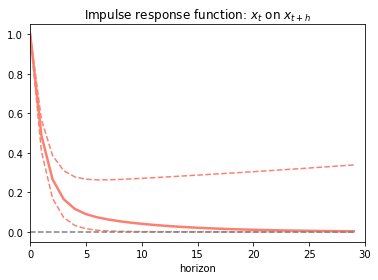

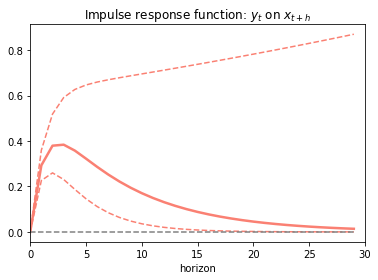

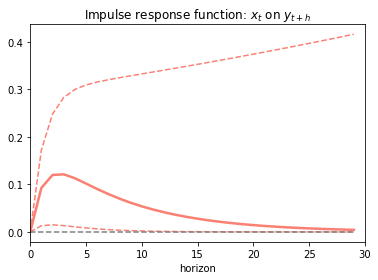

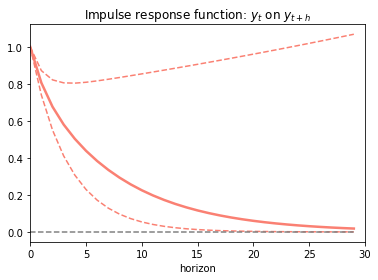

In [36]:
plt.plot(range(0,h),IRF_est[:,0,0], linewidth = 2.5, color = 'salmon',alpha = 2)
plt.plot(range(0,h), IRF_est_low[:,0,0],'--', color = 'salmon',alpha = 2)
plt.plot(range(0,h),IRF_est_up[:,0,0], '--', color = 'salmon',alpha = 2)
plt.plot(range(0,h),np.zeros(h), '--', color = 'grey')
plt.xlim(0, h)
plt.title("Impulse response function: $x_{t}$ on $x_{t+h}$")
plt.xlabel("horizon")
plt.show()
#
plt.plot(range(0,h),IRF_est[:,0,1], linewidth = 2.5, color = 'salmon',alpha = 2)
plt.plot(range(0,h), IRF_est_low[:,0,1],'--', color = 'salmon',alpha = 2)
plt.plot(range(0,h),IRF_est_up[:,0,1], '--', color = 'salmon',alpha = 2)
plt.plot(range(0,h),np.zeros(h), '--', color = 'grey')
plt.xlim(0, h)
plt.title("Impulse response function: $y_{t}$ on $x_{t+h}$")
plt.xlabel("horizon")
plt.show()
#
plt.plot(range(0,h),IRF_est[:,1,0], linewidth = 2.5, color = 'salmon',alpha = 2)
plt.plot(range(0,h), IRF_est_low[:,1,0],'--', color = 'salmon',alpha = 2)
plt.plot(range(0,h),IRF_est_up[:,1,0], '--', color = 'salmon',alpha = 2)
plt.plot(range(0,h),np.zeros(h), '--', color = 'grey')
plt.xlim(0, h)
plt.title("Impulse response function: $x_{t}$ on $y_{t+h}$")
plt.xlabel("horizon")
plt.show()
#
plt.plot(range(0,h),IRF_est[:,1,1], linewidth = 2.5, color = 'salmon',alpha = 2)
plt.plot(range(0,h), IRF_est_low[:,1,1], '--', color = 'salmon',alpha = 2)
plt.plot(range(0,h),IRF_est_up[:,1,1], '--', color = 'salmon',alpha = 2)
plt.plot(range(0,h),np.zeros(h), '--', color = 'grey')
plt.xlim(0, h)
plt.title("Impulse response function: $y_{t}$ on $y_{t+h}$")
plt.xlabel("horizon")
plt.show()

In my opinion, 95% is too much, so I repeat the same using 65% confidence bands:

In [37]:
PEL = np.zeros((2,2))
PEL[0,0] = results_x.conf_int(alpha=0.35)[0][0]
PEL[0,1] = results_x.conf_int(alpha=0.35)[1][0]
PEL[1,0] = results_y.conf_int(alpha=0.35)[0][0]
PEL[1,1] = results_y.conf_int(alpha=0.35)[1][0]
PEL = np.matrix(PEL)
PEU = np.zeros((2,2))
PEU[0,0] = results_x.conf_int(alpha=0.35)[0][1]
PEU[0,1] = results_x.conf_int(alpha=0.35)[1][1]
PEU[1,0] = results_y.conf_int(alpha=0.35)[0][1]
PEU[1,1] = results_y.conf_int(alpha=0.35)[1][1]
PEU = np.matrix(PEU)
IRF_est_low = np.zeros((h,2,2)) 
for i in range(0,h):
    A = PEL**i
    IRF_est_low[i,0,0] = A[0,0]
    IRF_est_low[i,0,1] = A[0,1]
    IRF_est_low[i,1,0] = A[1,0]
    IRF_est_low[i,1,1] = A[1,1]
IRF_est_up = np.zeros((h,2,2)) 
for i in range(0,h):
    B = PEU**i
    IRF_est_up[i,0,0] =  B[0,0]
    IRF_est_up[i,0,1] =  B[0,1]
    IRF_est_up[i,1,0] =  B[1,0]
    IRF_est_up[i,1,1] =  B[1,1]

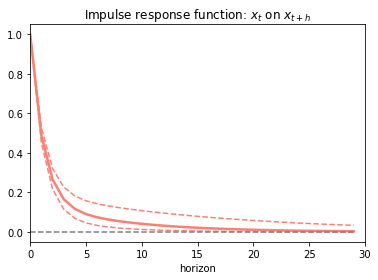

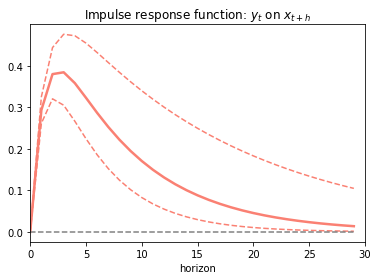

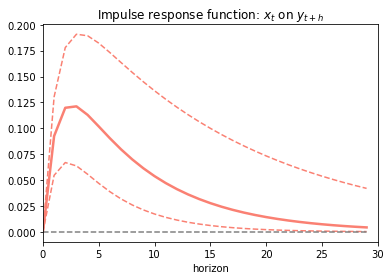

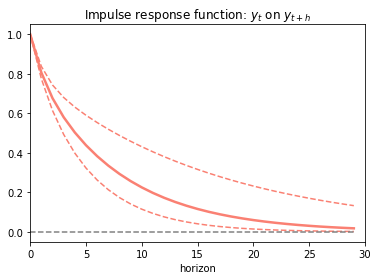

In [38]:
plt.plot(range(0,h),IRF_est[:,0,0], linewidth = 2.5, color = 'salmon',alpha = 2)
plt.plot(range(0,h), IRF_est_low[:,0,0],'--', color = 'salmon',alpha = 2)
plt.plot(range(0,h),IRF_est_up[:,0,0], '--', color = 'salmon',alpha = 2)
plt.plot(range(0,h),np.zeros(h), '--', color = 'grey')
plt.xlim(0, h)
plt.title("Impulse response function: $x_{t}$ on $x_{t+h}$")
plt.xlabel("horizon")
plt.show()
#
plt.plot(range(0,h),IRF_est[:,0,1], linewidth = 2.5, color = 'salmon',alpha = 2)
plt.plot(range(0,h), IRF_est_low[:,0,1],'--', color = 'salmon',alpha = 2)
plt.plot(range(0,h),IRF_est_up[:,0,1], '--', color = 'salmon',alpha = 2)
plt.plot(range(0,h),np.zeros(h), '--', color = 'grey')
plt.xlim(0, h)
plt.title("Impulse response function: $y_{t}$ on $x_{t+h}$")
plt.xlabel("horizon")
plt.show()
#
plt.plot(range(0,h),IRF_est[:,1,0], linewidth = 2.5, color = 'salmon',alpha = 2)
plt.plot(range(0,h), IRF_est_low[:,1,0],'--', color = 'salmon',alpha = 2)
plt.plot(range(0,h),IRF_est_up[:,1,0], '--', color = 'salmon',alpha = 2)
plt.plot(range(0,h),np.zeros(h), '--', color = 'grey')
plt.xlim(0, h)
plt.title("Impulse response function: $x_{t}$ on $y_{t+h}$")
plt.xlabel("horizon")
plt.show()
#
plt.plot(range(0,h),IRF_est[:,1,1], linewidth = 2.5, color = 'salmon',alpha = 2)
plt.plot(range(0,h), IRF_est_low[:,1,1], '--', color = 'salmon',alpha = 2)
plt.plot(range(0,h),IRF_est_up[:,1,1], '--', color = 'salmon',alpha = 2)
plt.plot(range(0,h),np.zeros(h), '--', color = 'grey')
plt.xlim(0, h)
plt.title("Impulse response function: $y_{t}$ on $y_{t+h}$")
plt.xlabel("horizon")
plt.show()